In [14]:
import numpy as np
import pandas as pd
import glob
from warnings import filterwarnings
filterwarnings('ignore') # Pandas'taki (normal) .mean() uyarılarını gizle

# ===============================================
# A) VERİ YÜKLEME VE HAZIRLAMA (FEATURE ENGINEERING İLE)
# ===============================================

path = '../datas/' 

# 1. Dosya Listelerini Oluşturma
training_years = [str(y) for y in range(1968, 2022)] 
validation_years = [str(y) for y in range(2022, 2024)]
test_file = path + "atp_matches_2024.csv" 

training_files = [path + f"atp_matches_{y}.csv" for y in training_years]
validation_files = [path + f"atp_matches_{y}.csv" for y in validation_years]

# 3. KULLANILACAK HAM SÜTUNLAR
# (Aynı kalabilir, kullanmadıklarımızı yüklesek bile 'melt'te atacağız)
RAW_FEATURES = [
    'tourney_id', 'tourney_name', 'surface', 'tourney_level', 'tourney_date', 'match_num',
    'winner_id', 'winner_hand', 'winner_ht', 'winner_age', 
    'loser_id', 'loser_hand', 'loser_ht', 'loser_age',
    'winner_rank_points', 'loser_rank_points',
    'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced',
    'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced'
]

# 2. Veri Yükleme Fonksiyonu
def load_and_concatenate(file_list, file_type='train'):
    li = []
    for filename in file_list:
        try:
            df_temp = pd.read_csv(filename, index_col=None, header=0, usecols=lambda c: c in RAW_FEATURES or c.startswith('atp_matches'))
            df_temp['dataset_marker'] = file_type
            li.append(df_temp)
        except Exception as e:
            continue
    if li:
        return pd.concat(li, axis=0, ignore_index=True)
    return pd.DataFrame() 

# 5. YENİ İŞ AKIŞI: VERİ HAZIRLAMA PİPELINE'I (RAM OPTİMİZELİ)
print("Adım 1/5: Tüm veri setleri yükleniyor (1968-2024)...")
df_train = load_and_concatenate(training_files, 'train')
df_val = load_and_concatenate(validation_files, 'val')
try:
    df_test = pd.read_csv(test_file, usecols=lambda c: c in RAW_FEATURES)
    df_test['dataset_marker'] = 'test'
except:
    df_test = pd.DataFrame()

df_all = pd.concat([df_train, df_val, df_test], axis=0, ignore_index=True)
df_all['tourney_date'] = pd.to_datetime(df_all['tourney_date'], format='%Y%m%d')
df_all.sort_values(by=['tourney_date', 'match_num'], inplace=True)
df_all.reset_index(drop=True, inplace=True)
df_all['match_id'] = df_all.index.astype(np.int32) # DTYPE OPTIMIZATION

print("Adım 2/5: Veri 'oyuncu-odaklı' formata eritiliyor (Melt)...")

# --- Veriyi "Erit" (Melt) ---
df_winners = df_all.copy()
df_winners['player_id'] = df_winners['winner_id']
df_winners['opponent_id'] = df_winners['loser_id']
df_winners['won'] = 1
df_winners = df_winners.rename(columns={
    'winner_hand': 'hand', 'winner_ht': 'ht', 'winner_age': 'age', 'winner_rank_points': 'rank_points',
    'w_ace': 'ace', 'w_df': 'df', 'w_svpt': 'svpt', 'w_1stIn': '1stIn', 'w_1stWon': '1stWon', 
    'w_2ndWon': '2ndWon', 'w_SvGms': 'SvGms', 'w_bpSaved': 'bpSaved', 'w_bpFaced': 'bpFaced'
})

df_losers = df_all.copy()
df_losers['player_id'] = df_losers['loser_id']
df_losers['opponent_id'] = df_losers['winner_id']
df_losers['won'] = 0
df_losers = df_losers.rename(columns={
    'loser_hand': 'hand', 'loser_ht': 'ht', 'loser_age': 'age', 'loser_rank_points': 'rank_points',
    'l_ace': 'ace', 'l_df': 'df', 'l_svpt': 'svpt', 'l_1stIn': '1stIn', 'l_1stWon': '1stWon', 
    'l_2ndWon': '2ndWon', 'l_SvGms': 'SvGms', 'l_bpSaved': 'bpSaved', 'l_bpFaced': 'bpFaced'
})

# İlgilendiğimiz sütunları seç
feature_cols = ['match_id', 'player_id', 'opponent_id', 'dataset_marker', 'tourney_date', 'surface',
                'hand', 'ht', 'age', 'rank_points', 'won', 'ace', 'df', 'svpt', '1stIn', '1stWon', 
                '2ndWon', 'SvGms', 'bpSaved', 'bpFaced']

df_player_matches = pd.concat([df_winners[feature_cols], df_losers[feature_cols]], axis=0)
df_player_matches.sort_values(by=['tourney_date', 'match_id'], inplace=True)
df_player_matches.reset_index(drop=True, inplace=True)

# --- DTYPE OPTIMIZASYONU ---
# RAM kullanımını agresif bir şekilde azalt
df_player_matches['player_id'] = df_player_matches['player_id'].astype(np.int32)
df_player_matches['opponent_id'] = df_player_matches['opponent_id'].astype(np.int32)
df_player_matches['surface'] = df_player_matches['surface'].astype('category')
df_player_matches['hand'] = df_player_matches['hand'].astype('category')

print("Adım 3/5: Kayan istatistikler hesaplanıyor (Sadece Kariyer/Zemin)...")

# --- Özellik (Feature) Hesaplama ---
# (Servis oranları hesaplaması aynı kalır)
df_player_matches['ace_rate'] = (df_player_matches['ace'] / df_player_matches['svpt']).fillna(0).astype(np.float32)
df_player_matches['1stIn_rate'] = (df_player_matches['1stIn'] / df_player_matches['svpt']).fillna(0).astype(np.float32)
df_player_matches['1stWon_rate'] = (df_player_matches['1stWon'] / df_player_matches['1stIn']).fillna(0).astype(np.float32)
df_player_matches['2ndWon_rate'] = (df_player_matches['2ndWon'] / (df_player_matches['svpt'] - df_player_matches['1stIn'])).fillna(0).astype(np.float32)
df_player_matches['won'] = df_player_matches['won'].astype(np.int8)

# Gruplar (Hesaplama için)
grouped_player = df_player_matches.groupby('player_id')
grouped_player_surface = df_player_matches.groupby(['player_id', 'surface'])

# --- İstatistikleri Ata (DÜZELTME: .transform() KULLANARAK) ---
# .transform(lambda x: ...), işlemi grup içinde yapar ve sonucu orijinal index'e geri eşler.
# .shift(1), veri sızıntısını (data leakage) önler.

print("   Hesaplanıyor: Kariyer İstatistikleri...")
# 1. Kariyer İstatistikleri (Expanding)
df_player_matches['career_win_rate'] = grouped_player['won'].transform(lambda x: x.expanding(min_periods=1).mean().shift(1)).astype(np.float32)
df_player_matches['career_ace_rate'] = grouped_player['ace_rate'].transform(lambda x: x.expanding(min_periods=1).mean().shift(1)).astype(np.float32)
df_player_matches['career_1stWon_rate'] = grouped_player['1stWon_rate'].transform(lambda x: x.expanding(min_periods=1).mean().shift(1)).astype(np.float32)

# 2. Momentum (RAM İÇİN KALDIRILDI)

print("   Hesaplanıyor: Zemin Uzmanlığı...")
# 3. Zemin Uzmanlığı (Kariyer)
# Bu işlem, (player_id, surface) grubu içinde aynı .transform() mantığını uygular.
df_player_matches['surface_win_rate'] = grouped_player_surface['won'].transform(lambda x: x.expanding(min_periods=1).mean().shift(1)).astype(np.float32)

# 4. H2H (RAM İÇİN KALDIRILDI)

# --- Statik Özellikleri Ayarla ---
df_player_matches['age'] = df_player_matches['age'].astype(np.float32)
df_player_matches['ht'] = df_player_matches['ht'].astype(np.float32)
df_player_matches['rank_points'] = df_player_matches['rank_points'].astype(np.float32)

# --- İhtiyacımız olan tüm sütunları listele ---
cols_to_keep = [
    'match_id', 'player_id', 'dataset_marker', # Anahtarlar
    'hand', 'ht', 'age', 'rank_points',       # Statik
    'career_win_rate', 'career_ace_rate', 'career_1stWon_rate', # Kariyer
    'surface_win_rate' # Zemin
]
# RAM'i boşaltmak için sadece ihtiyacımız olan sütunları tut
df_features = df_player_matches[cols_to_keep].copy()


# RAM Boşaltma (Artık df_player_matches'e ihtiyacımız yok)
del df_player_matches, grouped_player, grouped_player_surface
import gc
gc.collect()

print("Adım 4/5: Özellikler anonimleştirilmiş p1/p2 formatına birleştiriliyor...")
# --- Anonimleştirme ve Son Birleştirme ---
# (df_labels oluşturma kodu aynı kalır)
df_labels = df_all[['match_id', 'winner_id', 'loser_id', 'surface', 'dataset_marker']].copy()
df_labels['p1_id'] = np.where(np.random.rand(len(df_labels)) > 0.5, df_labels['winner_id'], df_labels['loser_id'])
df_labels['p2_id'] = np.where(df_labels['p1_id'] == df_labels['winner_id'], df_labels['loser_id'], df_labels['winner_id'])
df_labels['Y'] = (df_labels['p1_id'] == df_labels['winner_id']).astype(np.int8)

# Belleği optimize edilmiş df_features'i kullan
df_features['player_id'] = df_features['player_id'].astype(np.int32)
df_features['match_id'] = df_features['match_id'].astype(np.int32)
df_labels['p1_id'] = df_labels['p1_id'].astype(np.int32)
df_labels['p2_id'] = df_labels['p2_id'].astype(np.int32)
df_labels['match_id'] = df_labels['match_id'].astype(np.int32)

# (Merge/Birleştirme kodunun geri kalanı bu değişiklikle sorunsuz çalışmalıdır)
# p1 için birleştir
df_p1_features = df_features.rename(columns=lambda c: f"p1_{c}" if c not in ['match_id', 'player_id', 'dataset_marker'] else c)
df_final = pd.merge(df_labels, df_p1_features, 
                    left_on=['match_id', 'p1_id'], 
                    right_on=['match_id', 'player_id'], 
                    how='left')

# p2 için birleştir
df_p2_features = df_features.rename(columns=lambda c: f"p2_{c}" if c not in ['match_id', 'player_id', 'dataset_marker'] else c)
df_final = pd.merge(df_final, df_p2_features, 
                    left_on=['match_id', 'p2_id'], 
                    right_on=['match_id', 'player_id'], 
                    how='left')

# RAM Boşaltma
del df_features, df_p1_features, df_p2_features, df_labels, df_all, df_train, df_val, df_test
gc.collect()

print("Adım 5/5: Eksik veriler dolduruluyor ve setler ayrılıyor...")
# --- Veri Temizleme ve Son Hazırlık ---
df_final['p1_is_L'] = (df_final['p1_hand'] == 'L').astype(np.int8)
df_final['p2_is_L'] = (df_final['p2_hand'] == 'L').astype(np.int8)
df_final = pd.get_dummies(df_final, columns=['surface'], prefix='surface', dtype=np.int8)

# --- NİHAİ ÖZELLİK LİSTESİ (FINAL_FEATURES) ---
base_features = ['p1_age', 'p1_ht', 'p1_rank_points', 'p1_is_L', 
                 'p2_age', 'p2_ht', 'p2_rank_points', 'p2_is_L']
stat_features = [
    'p1_career_win_rate', 'p1_career_ace_rate', 'p1_career_1stWon_rate',
    'p1_surface_win_rate',
    'p2_career_win_rate', 'p2_career_ace_rate', 'p2_career_1stWon_rate',
    'p2_surface_win_rate'
]
surface_features = [col for col in df_final.columns if col.startswith('surface_')]
FINAL_FEATURES = base_features + stat_features + surface_features

# 6. Eksik Veri Doldurma (Imputation)
rate_cols = [col for col in FINAL_FEATURES if 'rate' in col]
df_final[rate_cols] = df_final[rate_cols].fillna(0.5) # Nötr

other_num_cols = [col for col in FINAL_FEATURES if col not in rate_cols and not col.startswith('surface_')]
# Eğitim setinin ortalamasını bul
train_means = df_final[df_final['dataset_marker_x'] == 'train'][other_num_cols].mean()
df_final[other_num_cols] = df_final[other_num_cols].fillna(train_means)
df_final[other_num_cols] = df_final[other_num_cols].fillna(0) # Güvenlik önlemi

# --- Veri Setlerini Ayır, Normalize et ve Numpy'a Çevir ---
df_train_processed = df_final[df_final['dataset_marker_x'] == 'train']
df_val_processed = df_final[df_final['dataset_marker_x'] == 'val']
df_test_processed = df_final[df_final['dataset_marker_x'] == 'test']

Y_train = df_train_processed['Y'].values.reshape(1, -1)
Y_val = df_val_processed['Y'].values.reshape(1, -1)
Y_test = df_test_processed['Y'].values.reshape(1, -1)

X_train_df = df_train_processed[FINAL_FEATURES]
X_val_df = df_val_processed[FINAL_FEATURES]
X_test_df = df_test_processed[FINAL_FEATURES]

# Normalleştirme (StandardScaler daha iyi olurdu, ama max scaler ile devam)
X_train_np = X_train_df.T.values.astype(np.float64) # Sinir ağı float64'ü tercih eder
X_max_per_feature = np.max(X_train_np, axis=1, keepdims=True)
X_max_per_feature[X_max_per_feature == 0] = 1.0

X_train = X_train_np / X_max_per_feature
X_val = X_val_df.T.values.astype(np.float64) / X_max_per_feature
X_test = X_test_df.T.values.astype(np.float64) / X_max_per_feature

# 8. Ana Eğitim Değişkenlerini Güncelleme
X = X_train
Y = Y_train
N_X = X.shape[0]

# Kontrol
print(f"\n--- Yeni Veri Yapısı (RAM Optimizeli FE Tamamlandı) ---")
print(f"Girdi Özellik Sayısı (N_X): {N_X} (Toplam {len(FINAL_FEATURES)} özellik)")
print(f"1. Eğitim Seti Boyutu: {X_train.shape[1]} örnek")
print(f"2. Doğrulama Seti Boyutu: {X_val.shape[1]} örnek")
print(f"3. Test Seti Boyutu: {X_test.shape[1]} örnek")
print(f"\nÖzellikler (Örnek): {FINAL_FEATURES[:5]}... vb.")

Adım 1/5: Tüm veri setleri yükleniyor (1968-2024)...
Adım 2/5: Veri 'oyuncu-odaklı' formata eritiliyor (Melt)...
Adım 3/5: Kayan istatistikler hesaplanıyor (Sadece Kariyer/Zemin)...
   Hesaplanıyor: Kariyer İstatistikleri...
   Hesaplanıyor: Zemin Uzmanlığı...
Adım 4/5: Özellikler anonimleştirilmiş p1/p2 formatına birleştiriliyor...
Adım 5/5: Eksik veriler dolduruluyor ve setler ayrılıyor...

--- Yeni Veri Yapısı (RAM Optimizeli FE Tamamlandı) ---
Girdi Özellik Sayısı (N_X): 20 (Toplam 20 özellik)
1. Eğitim Seti Boyutu: 186026 örnek
2. Doğrulama Seti Boyutu: 5903 örnek
3. Test Seti Boyutu: 3076 örnek

Özellikler (Örnek): ['p1_age', 'p1_ht', 'p1_rank_points', 'p1_is_L', 'p2_age']... vb.


In [15]:
# ===============================================
# YAPILANDIRMA: HİPER-PARAMETRELER (AYARLANABİLİR KISIM)
# ===============================================
N_X = X.shape[0]        # Girdi Boyutu
N_H = 32                # Gizli Katman Nöron Sayısı (DENEME İÇİN DEĞİŞTİRİLEBİLİR!)
N_Y = Y.shape[0]        # Çıktı Boyutu
LEARNING_RATE = 0.05    # Öğrenme Hızı (DENEME İÇİN DEĞİŞTİRİLEBİLİR!)
EPOCHS = 5000           # Eğitim Döngüsü Sayısı
PATIENCE = 3            # YENİ EKLENDİ: Kaç kontrol noktası boyunca sabredeceği

print(f"Girdi Özellik Sayısı (N_X): {N_X}")

Girdi Özellik Sayısı (N_X): 20


In [16]:
# ===============================================
# A) YARDIMCI FONKSİYONLAR (HELPER FUNCTIONS)
# ===============================================

def sigmoid(Z):
    """Sigmoid aktivasyon fonksiyonunu hesaplar. Çıktıyı 0 ile 1 arasına sıkıştırır."""
    A = 1 / (1 + np.exp(-Z))
    return A

def sigmoid_backward(A):
    """Sigmoid'in türevini (Geriye yayılım için) hesaplar: A * (1 - A)"""
    # Bu türev, hatanın gizli katmandan geriye doğru nasıl yayılacağını belirler.
    dZ = A * (1 - A) 
    return dZ

# ===============================================
# B) MODEL SINIFI VE BAŞLATMA
# ===============================================

def initialize_parameters(n_x, n_h, n_y):
    """
    Ağırlık ve sapmaları "Xavier (Glorot)" yöntemiyle başlatır.
    Bu, tanh aktivasyonu için 'vanishing gradient' sorununu önler.
    """
    
    # Hatalı Yöntem (Gradyanları sıfıra çökertiyor):
    # W1 = np.random.randn(n_h, n_x) * 0.01 
    # W2 = np.random.randn(n_y, n_h) * 0.01
    
    # DOĞRU YÖNTEM (Xavier):
    # Varyansı, giren nöron sayısına bölerek koru.
    
    W1 = np.random.randn(n_h, n_x) * np.sqrt(1 / n_x)
    b1 = np.zeros((n_h, 1))
    
    W2 = np.random.randn(n_y, n_h) * np.sqrt(1 / n_h)
    b2 = np.zeros((n_y, 1))
    
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    return parameters


def forward_propagation(X, parameters):
    """Girdiyi alır ve tahmini çıktıyı (A2) hesaplar."""
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # 1. Katman (Gizli Katman)
    # Z1 = W1 * X + b1
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1) 
    
    # 2. Katman (Çıkış Katmanı)
    # Z2 = W2 * A1 + b2
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2) # Tahminimiz (Y_hat)
    
    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
    return A2, cache

# D) MALİYET FONKSİYONU
def compute_cost(A2, Y):
    """
    İkili Çapraz Entropi maliyetini hesaplar.
    
    A2: Ağın tahmini (Y_hat)
    Y: Gerçek Etiketler
    """
    m = Y.shape[1] # Örnek sayısı (sütun sayısı)
    
    # !!! DÜZELTME: np.log(0) hatasını önlemek için kırpma (clipping) !!!
    epsilon = 1e-8 # Çok küçük bir sayı
    A2_clipped = np.clip(A2, epsilon, 1 - epsilon)
    # -------------------------------------------------------------
    
    # Çapraz Entropi formülünün iki ana terimini hesaplayın:
    # 1. terim: Y * log(A2_clipped)
    log_probs = Y * np.log(A2_clipped)
    
    # 2. terim: (1 - Y) * log(1 - A2_clipped)
    log_probs_complement = (1 - Y) * np.log(1 - A2_clipped)
    
    # Toplam Maliyet (Cost) J = -(1/m) * (terim1 + terim2) matrisinin tüm elemanlarının toplamı
    cost = - (1 / m) * (np.sum(log_probs + log_probs_complement))
    
    # Maliyetin tek bir sayı (skaler) olarak döndürülmesi gerekir.
    cost = np.squeeze(cost) 
    
    return cost

# E) GERİYE YAYILIM (BACKWARD PROPAGATION)
def backward_propagation(parameters, cache, X, Y):
    
    # 1. Gerekli Değişkenleri Çekme
    m = X.shape[1] # Örnek sayısı
    A1 = cache["A1"]
    A2 = cache["A2"]
    
    # Parametreleri al
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    # 2. Çıkış Katmanı Gradyanları (Layer 2)
    
    # dZ2 = A2 - Y (Çapraz Entropi ve Sigmoid kombinasyonundan gelen sadeleşmiş formül)
    dZ2 = A2 - Y
    
    # dW2 = (1/m) * dZ2 . A1^T
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    
    # db2 = dZ2'nin örnekler üzerinden ortalaması
    db2 = np.mean(dZ2, axis=1, keepdims=True)
    
    # 3. Gizli Katman Gradyanları (Layer 1)
    
    # Hatanın geriye yayılımı: W2^T . dZ2
    # Bu, hatanın W2 üzerinden Layer 1'deki nöronlara dağıtılmasıdır.
    dZ1_weighted = np.dot(W2.T, dZ2)
    
    # tanh türevi: 1 - A1^2
    dZ1 = dZ1_weighted * (1 - np.power(A1, 2))
    
    # dW1 = (1/m) * dZ1 . X^T
    dW1 = (1 / m) * np.dot(dZ1, X.T)
    
    # db1 = dZ1'in örnekler üzerinden ortalaması
    db1 = np.mean(dZ1, axis=1, keepdims=True)
    
    # Gradyanları bir sözlükte toplama
    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    
    return grads

# F) PARAMETRE GÜNCELLEME (GRADIENT DESCENT)
def update_parameters(parameters, grads, learning_rate):
    
    # Parametreleri al
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Gradyanları al
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    # Gradyan İnişi Kuralını Uygulama
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    # Güncellenmiş parametreleri sözlüğe kaydetme
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    
    return parameters

# G) ANA EĞİTİM FONKSİYONU (GÜNCELLENDİ: 1 KATMAN + ERKEN DURDURMA)
def train_ann(X, Y, X_val, Y_val, n_h, learning_rate, num_epochs, print_cost=False, patience=3):
    
    n_x = X.shape[0] # Girdi boyutu
    n_y = Y.shape[0] # Çıktı boyutu
    
    # 1. PARAMETRELERİ BAŞLATMA (1 katmanla)
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    costs = []
    validation_costs = [] 

    # --- Erken Durdurma Değişkenleri ---
    best_val_cost = np.inf
    patience_counter = 0
    best_parameters = {}
    best_epoch = 0
    print_interval = EPOCHS / 10 if (EPOCHS / 10) >= 1 else 1 # Yazdırma aralığı
    # ------------------------------------
    
    # 2. EĞİTİM DÖNGÜSÜ
    for i in range(num_epochs):
        
        # 1. İLERİ YAYILIM (Training Set)
        A2, cache = forward_propagation(X, parameters) # 1 Katmanlı: A2 döner
        
        # 2. MALİYET HESAPLAMA (Training Cost)
        cost = compute_cost(A2, Y) # 1 Katmanlı: A2 kullanılır
        
        # 3. GERİYE YAYILIM
        grads = backward_propagation(parameters, cache, X, Y)
        
        # 4. PARAMETRE GÜNCELLEME
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # 5. KONTROL NOKTASI
        if i % print_interval == 0:
            
            # Doğrulama setini sadece şimdi kontrol et
            A2_val, _ = forward_propagation(X_val, parameters) # 1 Katmanlı: A2_val
            cost_val = compute_cost(A2_val, Y_val) # 1 Katmanlı: A2_val
            
            costs.append(cost)
            validation_costs.append(cost_val)
            
            if print_cost:
                train_confidence = np.exp(-cost) * 100
                val_confidence = np.exp(-cost_val) * 100
                print(f"Epoch {i} | EĞİTİM Maliyeti: {cost:.4f} (Güven: %{train_confidence:.2f}) | DOĞRULAMA Maliyeti: {cost_val:.4f} (Güven: %{val_confidence:.2f})")
            
            # --- ERKEN DURDURMA KONTROLÜ ---
            if cost_val < best_val_cost:
                # İyileşme var
                best_val_cost = cost_val
                best_parameters = parameters.copy() # En iyi parametreleri kopyala
                best_epoch = i
                patience_counter = 0 # Sabrı sıfırla
                if print_cost:
                    print(f"          -> (Yeni en iyi model kaydedildi. Sabır sıfırlandı.)")
            else:
                # İyileşme yok
                patience_counter += 1
                if print_cost:
                    print(f"          -> (Sabır: {patience_counter}/{patience})")
            
            # Sabır taştı mı?
            if patience_counter >= patience:
                print(f"\n--- ERKEN DURDURMA TETİKLENDİ ---")
                print(f"Model, {patience} kontrol noktası ({int(patience * print_interval)} epoch) boyunca iyileşme göstermedi.")
                print(f"Eğitim durduruldu. En iyi epoch: {best_epoch} (Maliyet: {best_val_cost:.4f})")
                break # Eğitim döngüsünü sonlandır
            # ---------------------------------
                
    # Döngü bittiğinde (ya da erken durduğunda)
    # KAYDEDİLEN EN İYİ parametreleri döndür
    
    if not best_parameters:
        best_parameters = parameters
    
    return best_parameters, costs, validation_costs

In [17]:
# H) EĞİTİMİ BAŞLATMA VE SONUÇLARI GÖRSELLEŞTİRME

print(f"--- Yapay Sinir Ağı Eğitimi Başlatılıyor ---")
print(f"Girdi Boyutu (N_X): {N_X} | Gizli Katman (N_H): {N_H} | Örnek Sayısı (m): {X.shape[1]}")
print(f"Öğrenme Hızı: {LEARNING_RATE} | Epoch Sayısı: {EPOCHS} | Sabır: {PATIENCE}") # Güncellendi

# Modelin Eğitilmesi (!!! EĞİTİM BU SATIRDA BAŞLIYOR !!!)
optimized_parameters, costs, validation_costs = train_ann( # 3 değer döndürüyoruz
    X=X_train, 
    Y=Y_train, 
    X_val=X_val, # Doğrulama Seti
    Y_val=Y_val, # Doğrulama Etiketleri
    n_h=N_H, 
    learning_rate=LEARNING_RATE, 
    num_epochs=EPOCHS, 
    print_cost=True,
    patience=PATIENCE # YENİ ARGÜMAN EKLENDİ
)

print(f"\n--- Eğitim Tamamlandı ---")
print(f"Başlangıç EĞİTİM Maliyeti: {costs[0]:.4f}")
print(f"Nihai EĞİTİM Maliyeti (Epoch {EPOCHS}): {costs[-1]:.4f}")
print(f"Nihai DOĞRULAMA Maliyeti: {validation_costs[-1]:.4f}") # Doğrulama sonucunu da yazdırıyoruz

# Sonuçları Görselleştirme
epochs_list = np.arange(0, EPOCHS + 1, (EPOCHS / 10)) # X ekseni (0, 1000, 2000, ...) hazırlanır.


--- Yapay Sinir Ağı Eğitimi Başlatılıyor ---
Girdi Boyutu (N_X): 20 | Gizli Katman (N_H): 32 | Örnek Sayısı (m): 186026
Öğrenme Hızı: 0.05 | Epoch Sayısı: 5000 | Sabır: 3
Epoch 0 | EĞİTİM Maliyeti: 0.7055 (Güven: %49.39) | DOĞRULAMA Maliyeti: 0.7025 (Güven: %49.53)
          -> (Yeni en iyi model kaydedildi. Sabır sıfırlandı.)
Epoch 500 | EĞİTİM Maliyeti: 0.6547 (Güven: %51.96) | DOĞRULAMA Maliyeti: 0.6692 (Güven: %51.21)
          -> (Yeni en iyi model kaydedildi. Sabır sıfırlandı.)
Epoch 1000 | EĞİTİM Maliyeti: 0.6384 (Güven: %52.81) | DOĞRULAMA Maliyeti: 0.6588 (Güven: %51.75)
          -> (Yeni en iyi model kaydedildi. Sabır sıfırlandı.)
Epoch 1500 | EĞİTİM Maliyeti: 0.6335 (Güven: %53.08) | DOĞRULAMA Maliyeti: 0.6559 (Güven: %51.90)
          -> (Yeni en iyi model kaydedildi. Sabır sıfırlandı.)
Epoch 2000 | EĞİTİM Maliyeti: 0.6309 (Güven: %53.21) | DOĞRULAMA Maliyeti: 0.6539 (Güven: %52.00)
          -> (Yeni en iyi model kaydedildi. Sabır sıfırlandı.)
Epoch 2500 | EĞİTİM Maliyeti

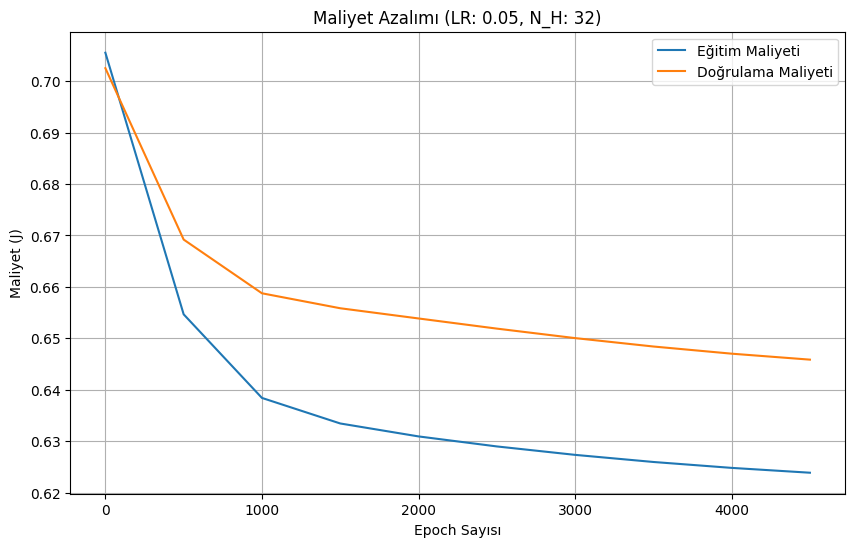

In [18]:
# Sonuçları Görselleştirme
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# --- DÜZELTME: X EKSENİNİ DİNAMİK OLARAK OLUŞTURMA ---
# 'costs' listesi kaç elemanlıysa (örn: 10), o kadar nokta oluştur.
# (print_interval'ı train_ann fonksiyonunuzdaki gibi hesaplıyoruz)
print_interval = EPOCHS / 10 if (EPOCHS / 10) >= 1 else 1

# epochs_list = [0, 1000, 2000, ..., 9000] (len(costs) == 10 ise)
# (Eğer Erken Durdurma 3000'de durursa, len(costs)=4 olur ve liste [0, 1000, 2000, 3000] olur)
epochs_list_actual = np.arange(0, len(costs)) * print_interval
# ----------------------------------------------------

# Eğitim Maliyeti
# Hata veren satır: plt.plot(epochs_list, costs, label="Eğitim Maliyeti")
plt.plot(epochs_list_actual, costs, label="Eğitim Maliyeti")

# Doğrulama Maliyeti
# (validation_costs listesinin uzunluğu daima costs listesiyle aynı olacaktır)
plt.plot(epochs_list_actual, validation_costs, label="Doğrulama Maliyeti")

# plt.title'daki N_H, 2 katmanlı mimaride N_H1 ve N_H2 olmalıdır
# Eğer 1 katmanlı mimarideyseniz 'N_H' doğrudur.
# 2 katmanlı için:
try:
    plt.title(f"Maliyet Azalımı (LR: {LEARNING_RATE}, H1: {N_H1}, H2: {N_H2})")
except NameError:
    # 1 katmanlı için:
    plt.title(f"Maliyet Azalımı (LR: {LEARNING_RATE}, N_H: {N_H})")

plt.xlabel("Epoch Sayısı")
plt.ylabel("Maliyet (J)")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# J) DOĞRULUK HESAPLAMA FONKSİYONU
def evaluate_accuracy(Y_prediction, Y_true):
    """
    Tahminleri (Y_prediction) gerçek etiketlerle (Y_true) karşılaştırarak
    modelin doğruluk skorunu hesaplar.
    """
    # NumPy'da iki matrisi karşılaştırmak için == kullanılır. 
    # Sonuç (True=1, False=0) matrisidir.
    correct_predictions = (Y_prediction == Y_true)
    
    # Ortalama almak, bize doğrudan doğru tahminlerin oranını (Doğruluğu) verir.
    accuracy = np.mean(correct_predictions) 
    
    return accuracy


# I) TAHMİN FONKSİYONU
def predict(parameters, X):
    """
    Eğitilmiş parametreleri kullanarak girdi X için tahmin yapar.
    
    Argümanlar:
    parameters -- Eğitilmiş W ve b parametreleri sözlüğü
    X -- Tahmin edilecek girdi matrisi (N, m)
    
    Döndürür:
    Y_prediction -- Girdi X için 0 veya 1 etiketlerinden oluşan NumPy vektörü
    """
    
    # Sadece İleri Yayılım yapıyoruz
    A2, cache = forward_propagation(X, parameters)
    
    # Karar Eşiği (Threshold): Olasılık 0.5'ten büyükse 1 (kazandı), değilse 0 (kaybetti).
    Y_prediction = (A2 > 0.5).astype(int)
    
    return Y_prediction

In [20]:
# K) NİHAİ PERFORMANS VE SONUÇ BLOĞU

# 1. Test Seti Tahmini (2024 verisi)
# optimized_parameters: train_ann'den gelen eğitilmiş W ve b değerleri
Y_pred_test = predict(optimized_parameters, X_test)

# 2. Doğruluk Hesaplama
# Modelin 2024 verisindeki nihai performansı
test_accuracy = evaluate_accuracy(Y_pred_test, Y_test)

print(f"\n--- Model Değerlendirmesi ---")
print(f"Eğitim Seti (1968-2021) Örnek Sayısı: {X.shape[1]}")
print(f"Doğrulama Seti (2022-2023) Örnek Sayısı: {X_val.shape[1]}")
print(f"Test Seti (2024) Örnek Sayısı: {X_test.shape[1]}")
print("-" * 35)
print(f"Nihai TEST Doğruluğu (2024): {test_accuracy*100:.2f}%")
print("-" * 35)


--- Model Değerlendirmesi ---
Eğitim Seti (1968-2021) Örnek Sayısı: 186026
Doğrulama Seti (2022-2023) Örnek Sayısı: 5903
Test Seti (2024) Örnek Sayısı: 3076
-----------------------------------
Nihai TEST Doğruluğu (2024): 62.65%
-----------------------------------
